In [2]:
%pip install ibapi


Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install ib-insync


     |████████████████████████████████| 72 kB 131 kB/s eta 0:00:01
  Using cached backports.zoneinfo-0.2.1-cp38-cp38-manylinux1_x86_64.whl (74 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol
ticker_symbol = 'AMZN'          
# Define the start and end dates
start_date = '1990-01-01'
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

# Fetch the data from Yahoo Finance
AMZN = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the first few rows of the data
print(AMZN.head())

# Save the data to a CSV file
AMZN.to_csv('AMZN.csv')


[*********************100%%**********************]  1 of 1 completed


                Open      High       Low     Close  Adj Close      Volume
Date                                                                     
1997-05-15  0.121875  0.125000  0.096354  0.097917   0.097917  1443120000
1997-05-16  0.098438  0.098958  0.085417  0.086458   0.086458   294000000
1997-05-19  0.088021  0.088542  0.081250  0.085417   0.085417   122136000
1997-05-20  0.086458  0.087500  0.081771  0.081771   0.081771   109344000
1997-05-21  0.081771  0.082292  0.068750  0.071354   0.071354   377064000


MovingAverageCrossStrategy
On a daily timeframe, over a number of years, with long lookback periods, few signals are generated
on a single stock and thus it is easy to manually verify that the system is behaving as would be
expected.
In order to actually generate such a simulation based on the prior backtesting code we need to
subclass the Strategy object as described in the previous chapter to create the MovingAverageCrossStrategy
object, which will contain the logic of the simple moving averages and the generation of trading
signals.

In [4]:
import datetime
import numpy as np
from typing import Dict, List

from strategy import Strategy
from event import SignalEvent
from backtest import Backtest
from data import HistoricCSVDataHandler
from execution import SimulatedExecutionHandler
from portfolio import Portfolio


class MovingAverageCrossStrategy(Strategy):
    """
    Carries out a basic Moving Average Crossover strategy with a
    short/long simple weighted moving average. Default short/long
    windows are 100/400 periods respectively.
    """

    def __init__(
        self, bars: HistoricCSVDataHandler, events: List[SignalEvent], 
        short_window: int = 100, long_window: int = 400
    ):
        """
        Initializes the Moving Average Cross Strategy.

        Parameters:
        bars - The DataHandler object that provides bar information.
        events - The Event Queue object.
        short_window - The short moving average lookback period.
        long_window - The long moving average lookback period.
        """
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()

    def _calculate_initial_bought(self) -> Dict[str, str]:
        """
        Initializes the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        return {symbol: 'OUT' for symbol in self.symbol_list}

    def calculate_signals(self, event) -> None:
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.

        Parameters:
        event - A MarketEvent object.
        """
        if event.type == 'MARKET':
            for symbol in self.symbol_list:
                bars = self.bars.get_latest_bars_values(
                    symbol, "adj_close", N=self.long_window
                )
                bar_date = self.bars.get_latest_bar_datetime(symbol)
                
                if bars is not None and len(bars) >= self.long_window:
                    short_sma = np.mean(bars[-self.short_window:])
                    long_sma = np.mean(bars[-self.long_window:])

                    dt = datetime.datetime.utcnow()
                    sig_dir = ""

                    if short_sma > long_sma and self.bought[symbol] == "OUT":
                        print(f"LONG: {bar_date}")
                        sig_dir = 'LONG'
                        signal = SignalEvent(1, symbol, dt, sig_dir, 1.0)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'
                    elif short_sma < long_sma and self.bought[symbol] == "LONG":
                        print(f"SHORT: {bar_date}")
                        sig_dir = 'EXIT'
                        signal = SignalEvent(1, symbol, dt, sig_dir, 1.0)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'


if __name__ == "__main__":
    csv_dir = '/home/ed/AlgorithmicTrading/algorithmic_trading_book-master/sat_source/chapter15/'  # CHANGE THIS TO YOUR ACTUAL CSV DIRECTORY
    symbol_list = ['AAPL']
    initial_capital = 100000.0
    heartbeat = 0.0
    start_date = datetime.datetime(1990, 1, 1, 0, 0, 0)

    backtest = Backtest(
        csv_dir, symbol_list, initial_capital, heartbeat, 
        start_date, HistoricCSVDataHandler, SimulatedExecutionHandler, 
        Portfolio, MovingAverageCrossStrategy
    )
    backtest.simulate_trading()


Creating DataHandler, Strategy, Portfolio and ExecutionHandler
LONG: 1991-07-31 00:00:00
SHORT: 1992-08-06 00:00:00
LONG: 1993-01-20 00:00:00
SHORT: 1993-06-10 00:00:00
LONG: 1994-11-04 00:00:00
SHORT: 1996-01-08 00:00:00
LONG: 1998-04-07 00:00:00
SHORT: 2000-11-16 00:00:00
LONG: 2002-04-05 00:00:00
SHORT: 2002-08-12 00:00:00
LONG: 2003-08-25 00:00:00
SHORT: 2008-11-04 00:00:00
LONG: 2009-08-07 00:00:00
SHORT: 2013-03-18 00:00:00
LONG: 2013-12-31 00:00:00
SHORT: 2016-01-14 00:00:00
LONG: 2016-11-25 00:00:00
SHORT: 2019-03-07 00:00:00
LONG: 2019-06-10 00:00:00
SHORT: 2022-12-15 00:00:00
LONG: 2023-05-25 00:00:00
Creating summary stats...
Creating equity curve...
                    AAPL         cash  commission          total   returns  \
datetime                                                                     
2024-08-05  20902.806091  94900.59174        27.3  115803.397832 -0.009052   
2024-08-06  20699.040222  94900.59174        27.3  115599.631962 -0.001760   
2024-08-07  20957.

##S&P500 Forecasting Trade
The rules for this strategy are as follows:
1. Fit a forecasting model to a subset of S&P500 data. This could be Logistic Regression,
a Discriminant Analyser (Linear or Quadratic), a Support Vector Machine or a Random
Forest. The procedure to do this was outlined in the Forecasting chapter.
2. Use two prior lags of adjusted closing returns data as a predictor for tomorrow’s returns. If
the returns are predicted as positive then go long. If the returns are predicted as negative
then exit. We’re not going to consider short selling for this particular strategy.

In [3]:
import datetime
from dataclasses import dataclass
import pandas as pd
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

from strategy import Strategy
from event import SignalEvent
from backtest import Backtest
from data import HistoricCSVDataHandler
from execution import SimulatedExecutionHandler
from portfolio import Portfolio
from create_lagged_series import create_lagged_series

@dataclass
class SignalEvent:
    """
    Handles the event of sending a Signal from a Strategy object.
    This is received by a Portfolio object and acted upon.
    """
    strategy_id: int
    symbol: str
    datetime: datetime.datetime
    signal_type: str
    strength: float
    type: str = 'SIGNAL'


class SPYDailyForecastStrategy(Strategy):
    """
    S&P500 forecast strategy. It uses a Quadratic Discriminant
    Analysis (QDA) to predict the returns for a subsequent time
    period and then generates long/exit signals based on the
    prediction.
    """

    def __init__(self, bars: HistoricCSVDataHandler, events):
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.datetime_now = datetime.datetime.utcnow()

        self.model_start_date = datetime.datetime(2001, 1, 10)
        self.model_end_date = datetime.datetime(2005, 12, 31)
        self.model_start_test_date = datetime.datetime(2005, 1, 1)

        self.long_market = False
        self.short_market = False
        self.bar_index = 0

        self.model = self.create_symbol_forecast_model()

    def create_symbol_forecast_model(self) -> QDA:
        """
        Create a Quadratic Discriminant Analysis model to predict market direction.
        """
        # Create a lagged series of the S&P500 US stock market index
        snpret = create_lagged_series(
            self.symbol_list[0], self.model_start_date, 
            self.model_end_date, lags=5
        )

        # Use the prior two days of returns as predictor 
        # values, with direction as the response
        X = snpret[["Lag1", "Lag2"]]
        y = snpret["Direction"]

        # Create training and test sets
        start_test = self.model_start_test_date
        X_train = X[X.index < start_test]
        X_test = X[X.index >= start_test]
        y_train = y[y.index < start_test]
        y_test = y[y.index >= start_test]
       
        model = QDA()
        model.fit(X_train, y_train)
        return model

    def calculate_signals(self, event) -> None:
        """
        Calculate the SignalEvents based on market data.
        """
        sym = self.symbol_list[0]
        dt = self.datetime_now

        if event.type == 'MARKET':
            self.bar_index += 1
            if self.bar_index > 5:
                lags = self.bars.get_latest_bars_values(
                    sym, "returns", N=3
                )
                pred_series = pd.Series(
                    {
                        'Lag1': lags[1] * 100.0, 
                        'Lag2': lags[2] * 100.0
                    }
                )
                pred = self.model.predict([pred_series])[0]
                if pred > 0 and not self.long_market:
                    self.long_market = True
                    signal = SignalEvent(1, sym, dt, 'LONG', 1.0)
                    self.events.put(signal)

                if pred < 0 and self.long_market:
                    self.long_market = False
                    signal = SignalEvent(1, sym, dt, 'EXIT', 1.0)
                    self.events.put(signal)


if __name__ == "__main__":
    csv_dir = '/home/ed/AlgorithmicTrading/algorithmic_trading_book-master/sat_source/chapter15'  # CHANGE THIS!
    symbol_list = ['SPY']
    initial_capital = 100000.0
    heartbeat = 0.0
    start_date = datetime.datetime(2006, 1, 3)

    backtest = Backtest(
        csv_dir, symbol_list, initial_capital, heartbeat, 
        start_date, HistoricCSVDataHandler, SimulatedExecutionHandler, 
        Portfolio, SPYDailyForecastStrategy
    )
    backtest.simulate_trading()


Creating DataHandler, Strategy, Portfolio and ExecutionHandler


[*********************100%%**********************]  1 of 1 completed
/home/ed/AlgorithmicTrading/trading/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/home/ed/AlgorithmicTrading/trading/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/home/ed/AlgorithmicTrading/trading/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/home/ed/AlgorithmicTrading/trading/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/home/ed/AlgorithmicTrading/trading/lib/python3.8/site-packages/skl

Creating summary stats...
Creating equity curve...
                     SPY           cash  commission          total   returns  \
datetime                                                                       
2024-08-06  52215.002441  100474.086656      1017.9  152689.089098  0.003134   
2024-08-07  51865.997314  100474.086656      1017.9  152340.083971 -0.002286   
2024-08-08  53065.002441  100474.086656      1017.9  153539.089098  0.007871   
2024-08-09      0.000000  153537.789098      1019.2  153537.789098 -0.000008   
2024-08-12  53327.001953  100237.490074      1020.5  153564.492027  0.000174   
2024-08-13  54203.997803  100237.490074      1020.5  154441.487877  0.005711   
2024-08-14  54375.000000  100237.490074      1020.5  154612.490074  0.001107   
2024-08-15  55307.000732  100237.490074      1020.5  155544.490807  0.006028   
2024-08-16  55430.999756  100237.490074      1020.5  155668.489830  0.000797   
2024-08-16  55430.999756  100237.490074      1020.5  155668.489830  0

Mean-Reverting Equity Pairs Trade

In [6]:

import datetime
from dataclasses import dataclass
import queue  # Add this import statement

import numpy as np
import pandas as pd
import statsmodels.api as sm

from strategy import Strategy
from event import SignalEvent
from backtest import Backtest
from hft_data import HistoricCSVDataHandlerHFT
from hft_portfolio import PortfolioHFT
from execution import SimulatedExecutionHandler


@dataclass
class SignalEvent:
    """
    Handles the event of sending a Signal from a Strategy object.
    This is received by a Portfolio object and acted upon.
    """
    strategy_id: int
    symbol: str
    datetime: datetime.datetime
    signal_type: str
    strength: float
    type: str = 'SIGNAL'


class IntradayOLSMRStrategy(Strategy):
    """
    Uses ordinary least squares (OLS) to perform a rolling linear
    regression to determine the hedge ratio between a pair of equities.
    The z-score of the residuals time series is then calculated in a
    rolling fashion and if it exceeds an interval of thresholds
    (defaulting to [0.5, 3.0]) then a long/short signal pair are generated
    (for the high threshold) or an exit signal pair are generated (for the
    low threshold).
    """

    def __init__(
        self, bars: HistoricCSVDataHandlerHFT, events: queue.Queue, 
        ols_window: int = 100, zscore_low: float = 0.5, zscore_high: float = 3.0
    ):
        """
        Initializes the stat arb strategy.

        Parameters:
        bars - The DataHandler object that provides bar information
        events - The Event Queue object.
        """
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.ols_window = ols_window
        self.zscore_low = zscore_low
        self.zscore_high = zscore_high

        self.pair = ('GOOG', 'AMZN')
        self.datetime = datetime.datetime.utcnow()

        self.long_market = False
        self.short_market = False

    def calculate_xy_signals(self, zscore_last: float):
        """
        Calculates the actual x, y signal pairings
        to be sent to the signal generator.

        Parameters:
        zscore_last - The current zscore to test against
        """
        y_signal = None
        x_signal = None
        p0 = self.pair[0]
        p1 = self.pair[1]
        dt = self.datetime
        hr = abs(self.hedge_ratio)

        if zscore_last <= -self.zscore_high and not self.long_market:
            self.long_market = True
            y_signal = SignalEvent(1, p0, dt, 'LONG', 1.0)
            x_signal = SignalEvent(1, p1, dt, 'SHORT', hr)

        if abs(zscore_last) <= self.zscore_low and self.long_market:
            self.long_market = False
            y_signal = SignalEvent(1, p0, dt, 'EXIT', 1.0)
            x_signal = SignalEvent(1, p1, dt, 'EXIT', 1.0)

        if zscore_last >= self.zscore_high and not self.short_market:
            self.short_market = True
            y_signal = SignalEvent(1, p0, dt, 'SHORT', 1.0)
            x_signal = SignalEvent(1, p1, dt, 'LONG', hr)

        if abs(zscore_last) <= self.zscore_low and self.short_market:
            self.short_market = False
            y_signal = SignalEvent(1, p0, dt, 'EXIT', 1.0)
            x_signal = SignalEvent(1, p1, dt, 'EXIT', 1.0)

        return y_signal, x_signal

    def calculate_signals_for_pairs(self):
        """
        Generates a new set of signals based on the mean reversion
        strategy.

        Calculates the hedge ratio between the pair of tickers. 
        We use OLS for this, although we should ideally use CADF.
        """
        y = self.bars.get_latest_bars_values(
            self.pair[0], "close", N=self.ols_window
        )
        x = self.bars.get_latest_bars_values(
            self.pair[1], "close", N=self.ols_window
        )

        if y is not None and x is not None:
            if len(y) >= self.ols_window and len(x) >= self.ols_window:
                self.hedge_ratio = sm.OLS(y, sm.add_constant(x)).fit().params[1]

                spread = y - self.hedge_ratio * x
                zscore_last = ((spread - spread.mean()) / spread.std())[-1]

                y_signal, x_signal = self.calculate_xy_signals(zscore_last)
                if y_signal is not None and x_signal is not None:
                    self.events.put(y_signal)
                    self.events.put(x_signal)

    def calculate_signals(self, event):
        """
        Calculate the SignalEvents based on market data.
        """
        if event.type == 'MARKET':
            self.calculate_signals_for_pairs()


if __name__ == "__main__":
    csv_dir = '/home/ed/AlgorithmicTrading/algorithmic_trading_book-master/sat_source/chapter15' #CHANGE THIS!
    symbol_list = ['GOOG', 'AMZN']
    initial_capital = 100000.0
    heartbeat = 0.0
    start_date = datetime.datetime(2007, 11, 8, 10, 41, 0)

    backtest = Backtest(
        csv_dir, symbol_list, initial_capital, heartbeat, 
        start_date, HistoricCSVDataHandlerHFT, SimulatedExecutionHandler, 
        PortfolioHFT, IntradayOLSMRStrategy
    )
    backtest.simulate_trading()


Creating DataHandler, Strategy, Portfolio and ExecutionHandler
Creating summary stats...
Creating equity curve...
            GOOG  AMZN          cash  commission         total  returns  \
datetime                                                                  
2024-08-07   0.0   0.0  99077.824585       140.4  99077.824585      0.0   
2024-08-08   0.0   0.0  99077.824585       140.4  99077.824585      0.0   
2024-08-09   0.0   0.0  99077.824585       140.4  99077.824585      0.0   
2024-08-12   0.0   0.0  99077.824585       140.4  99077.824585      0.0   
2024-08-13   0.0   0.0  99077.824585       140.4  99077.824585      0.0   
2024-08-14   0.0   0.0  99077.824585       140.4  99077.824585      0.0   
2024-08-15   0.0   0.0  99077.824585       140.4  99077.824585      0.0   
2024-08-16   0.0   0.0  99077.824585       140.4  99077.824585      0.0   
2024-08-19   0.0   0.0  99077.824585       140.4  99077.824585      0.0   
2024-08-19   0.0   0.0  99077.824585       140.4  99077.82458

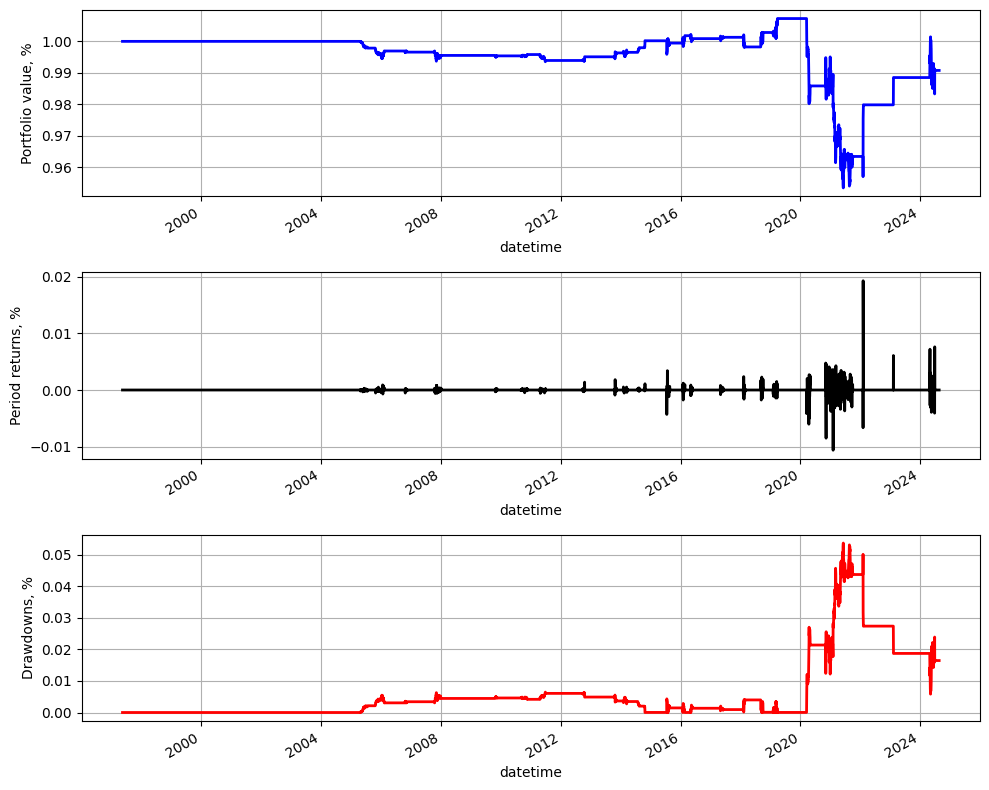

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def plot_equity_curve(data: pd.DataFrame) -> None:
    """
    Plots the equity curve, period returns, and drawdowns.

    Parameters:
    - data: A pandas DataFrame containing 'equity_curve', 'returns', and 'drawdown' columns.
    """
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))
    fig.patch.set_facecolor('white')

    # Plot the equity curve
    axes[0].set_ylabel('Portfolio value, %')
    data['equity_curve'].plot(ax=axes[0], color="blue", lw=2)
    axes[0].grid(True)

    # Plot the period returns
    axes[1].set_ylabel('Period returns, %')
    data['returns'].plot(ax=axes[1], color="black", lw=2)
    axes[1].grid(True)

    # Plot the drawdowns
    axes[2].set_ylabel('Drawdowns, %')
    data['drawdown'].plot(ax=axes[2], color="red", lw=2)
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


def load_data(filepath: str) -> pd.DataFrame:
    """
    Loads the CSV data from the given filepath and returns a DataFrame.

    Parameters:
    - filepath: The path to the CSV file.

    Returns:
    - A pandas DataFrame with the loaded data.
    """
    data = pd.read_csv(filepath, header=0, parse_dates=True, index_col=0)
    data.sort_index(inplace=True)
    return data


if __name__ == "__main__":
    filepath = "equity.csv"  # Ensure this path is correct
    if os.path.exists(filepath):
        data = load_data(filepath)
        plot_equity_curve(data)
    else:
        print(f"File {filepath} does not exist.")
